In [1]:
import pickle
import numpy as np
import pandas as pd
import json

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from tensorflow.keras.metrics import Precision, Recall
import tensorflow.keras.backend as K
import seaborn as sns


import matplotlib.pyplot as plt

2023-06-25 04:33:42.987258: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-25 04:33:44.066302: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Load data

In [2]:
with open("data/X_train.pickle", "rb") as X_train_file, open(
    "data/X_test.pickle", "rb"
) as X_test_file, open("data/Y_train.pickle", "rb") as Y_train_file, open(
    "data/Y_test.pickle", "rb"
) as Y_test_file, open(
    "data/vocabulary.json", "rt"
) as vocabulary_file, open(
    "models/tweets_model.pickle", "rb"
) as model_file:
    X_test = pickle.load(X_test_file)
    X_train = pickle.load(X_train_file)
    Y_train = pickle.load(Y_train_file)
    Y_test = pickle.load(Y_test_file)
    vocabulary = json.load(vocabulary_file)
    model = pickle.load(model_file)

2023-06-25 04:33:47.924410: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-25 04:33:48.133050: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-25 04:33:48.133148: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-25 04:33:48.135158: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-25 04:33:48.135225: I tensorflow/compile

In [3]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (32897, 5000)
X_test shape: (8225, 5000)
Y_train shape: (32897, 3)
Y_test shape: (8225, 3)


In [4]:
def from_categorical(matrix):
    return np.argmax(matrix, axis=1)

In [5]:
y_train = from_categorical(Y_train)
y_test = from_categorical(Y_test)

print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

y_train shape: (32897,)
y_test shape: (8225,)


In [6]:
features_names = list(vocabulary.keys())[:5000]
print(f"Number of features: {len(features_names)}")

Number of features: 5000


In [15]:
SHAP_NUM_OF_TWEETS = 10


In [26]:
import shap

In [28]:
kernel_explainer = shap.KernelExplainer(model, shap.sample(X_train, SHAP_NUM_OF_TWEETS))
kernel_shap_values = np.array(kernel_explainer.shap_values(shap.sample(X_train, SHAP_NUM_OF_TWEETS), max_evals=2*5000+1))

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


In [31]:
explainer = shap.Explainer(model, shap.sample(X_train, SHAP_NUM_OF_TWEETS))
shap_values = explainer(shap.sample(X_train, SHAP_NUM_OF_TWEETS), max_evals=2*5000+1)

Permutation explainer: 11it [00:13,  3.38s/it]                        


In [32]:
print(f"kernel_shap_values shape: {kernel_shap_values.shape}")
print(f"shap_values shape: {shap_values.shape}")

kernel_shap_values shape: (3, 10, 5000)
shap_values shape: (10, 5000, 3)


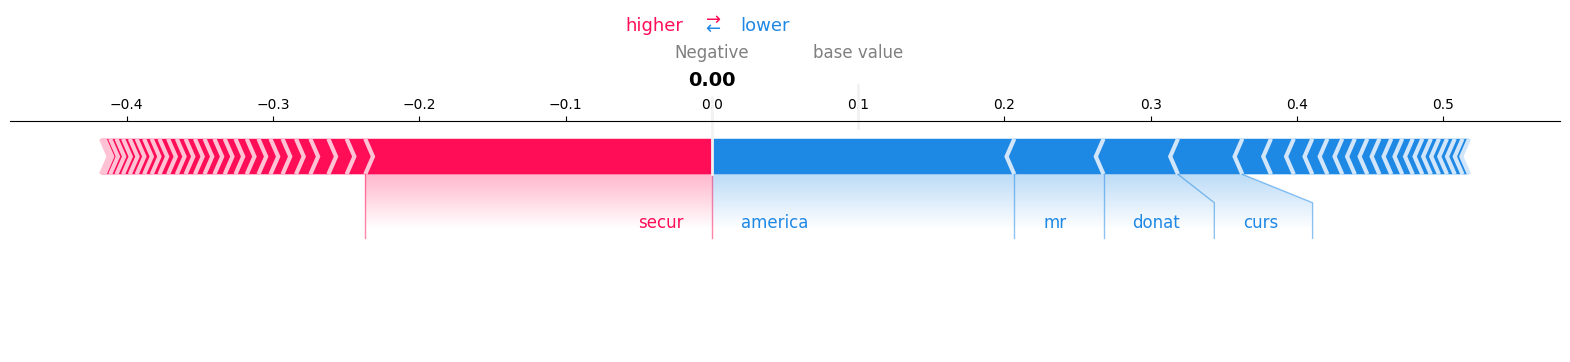

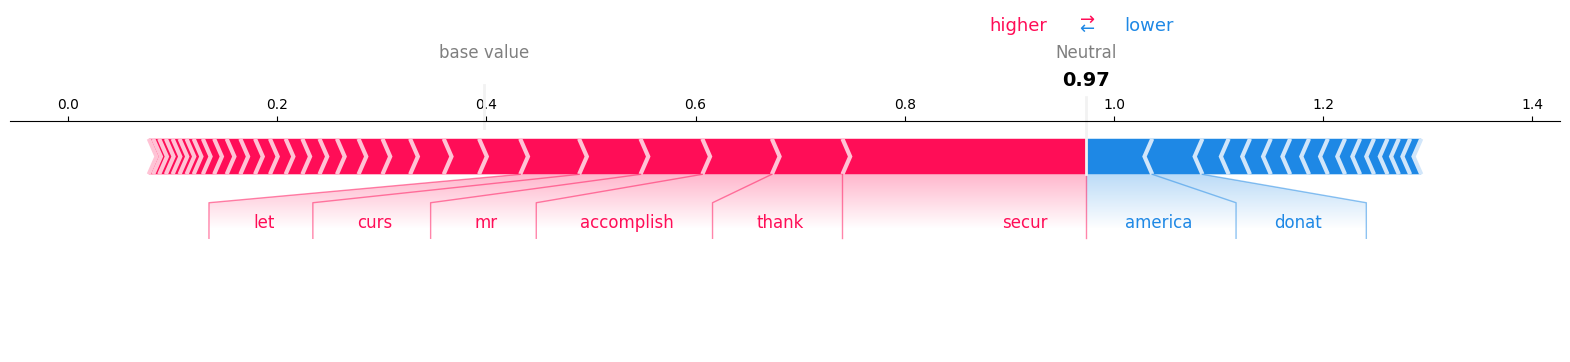

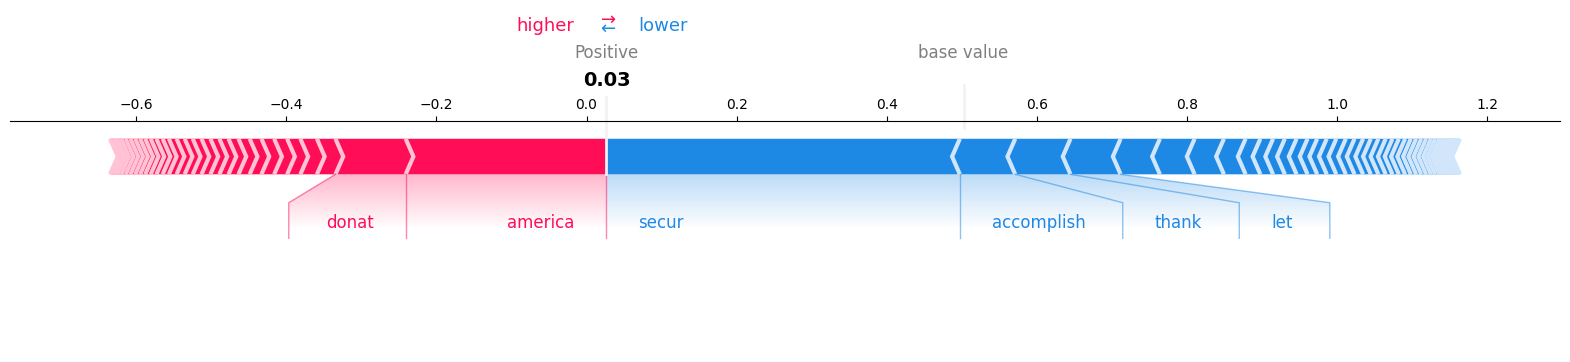

In [33]:
for i in range(3):
    sample_v = kernel_shap_values[i][0]
    shap.force_plot(
        kernel_explainer.expected_value[i],
        sample_v,
        features=features_names,
        out_names=["Negative", "Neutral", "Positive"][i],
        matplotlib=True,
    )

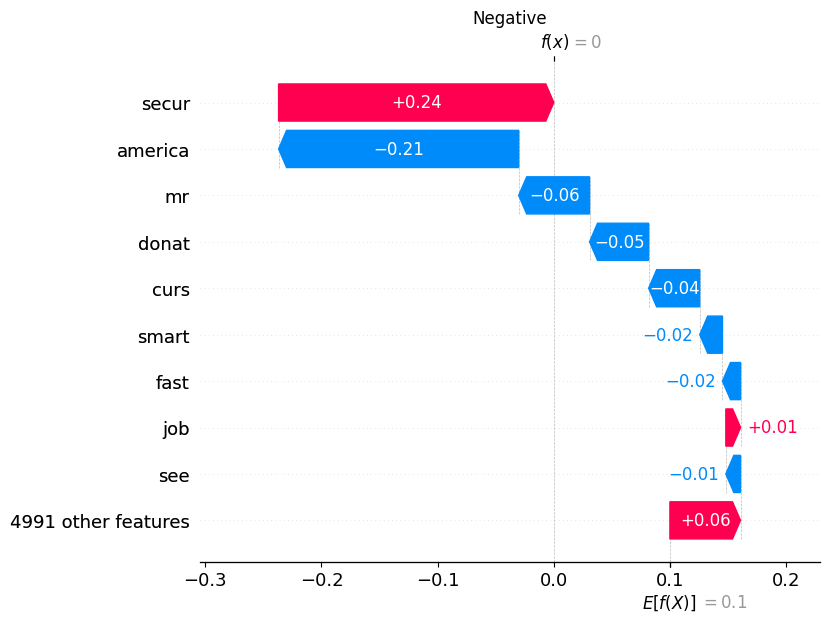

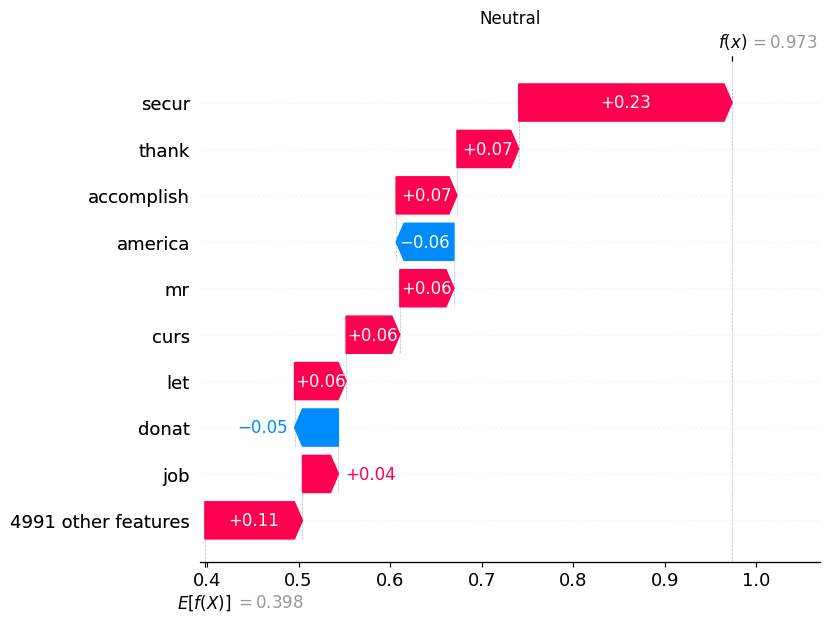

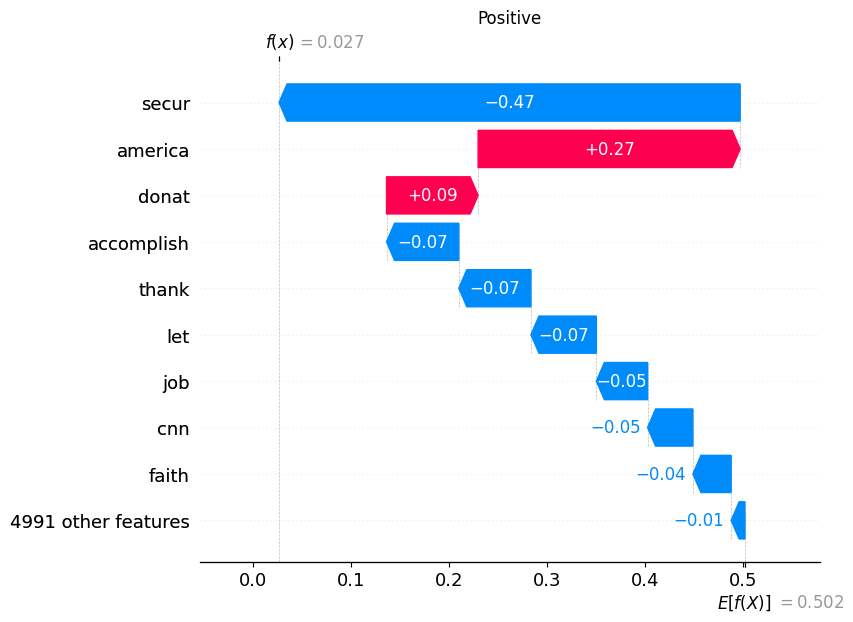

In [49]:
import shap_fixes

for i in range(3):
    plt.title(["Negative", "Neutral", "Positive"][i])
    shap_fixes.waterfall_legacy(
        kernel_explainer.expected_value[i], kernel_shap_values[i][0], feature_names=features_names
    )

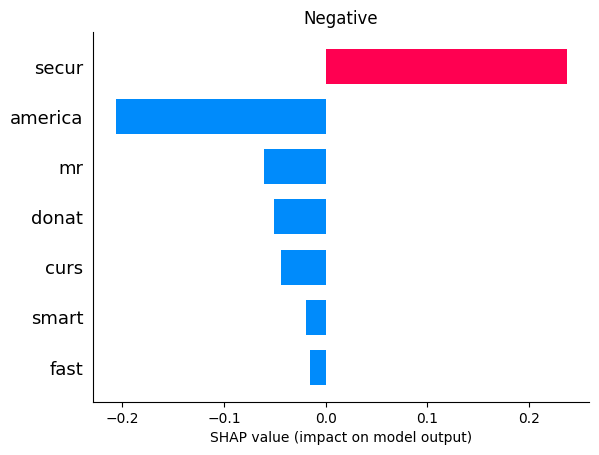

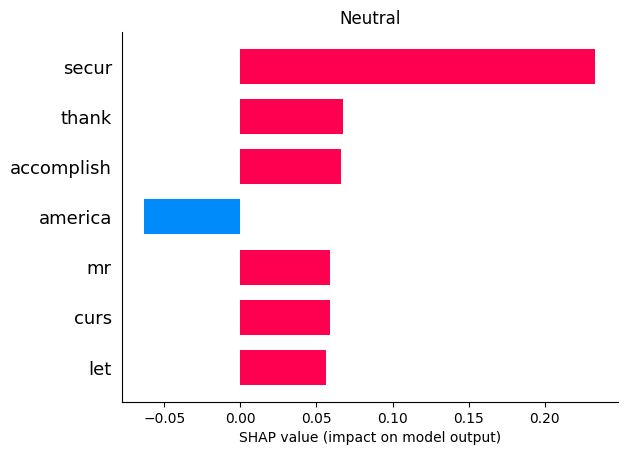

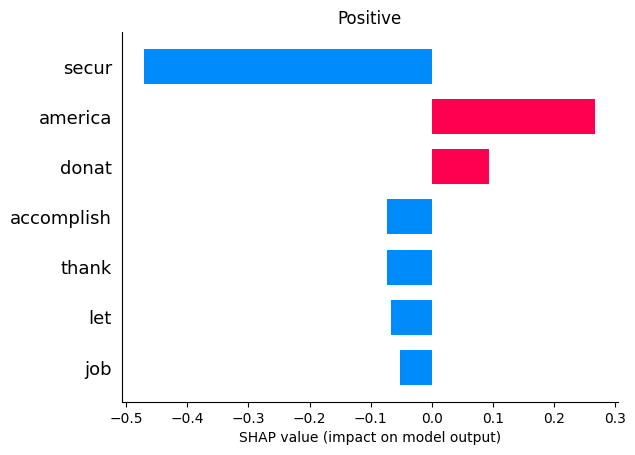

In [52]:
for i in range(3):
    plt.title(["Negative", "Neutral", "Positive"][i])
    shap.bar_plot(kernel_shap_values[i][0], feature_names=features_names)

In [54]:
shap.initjs()
shap.force_plot(
    kernel_explainer.expected_value[0],
    kernel_shap_values[0],
    features=features_names
)

In [56]:
shap.force_plot(
    kernel_explainer.expected_value[1],
    kernel_shap_values[1],
    features=features_names
)

In [57]:
shap.force_plot(
    kernel_explainer.expected_value[2],
    kernel_shap_values[2],
    features=features_names
)

not enough data in bin #1 for feature job, so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #1 for feature cnn, so it'll be ignored. Try increasing the number of records to plot.


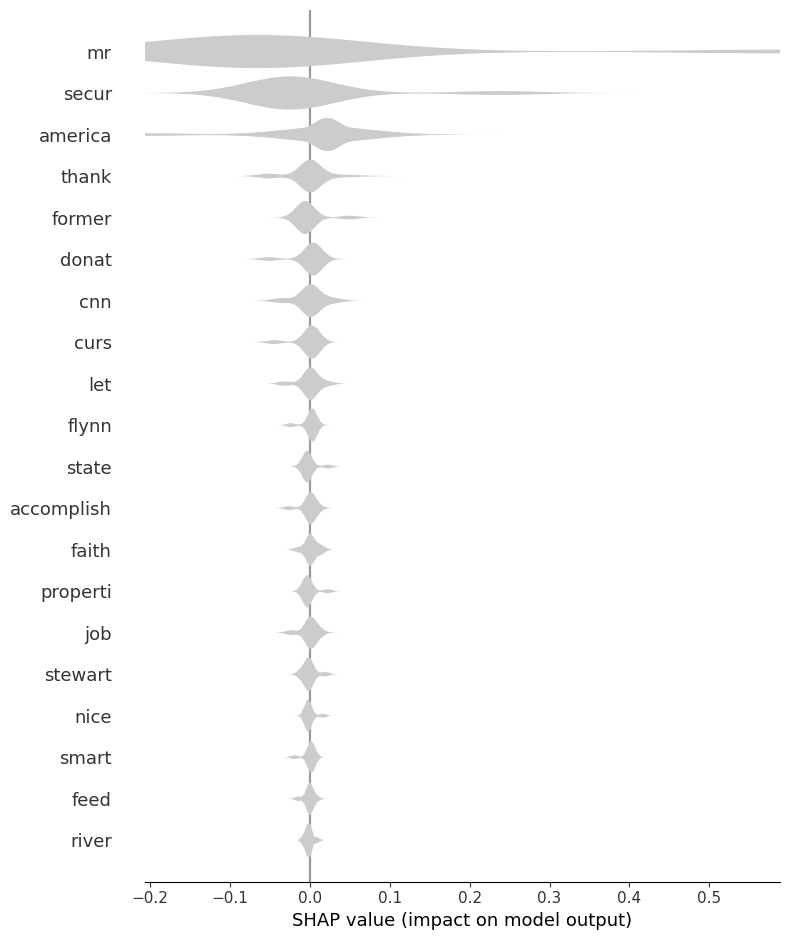

In [80]:
shap.summary_plot(kernel_shap_values[0], X_train[:SHAP_NUM_OF_TWEETS],  feature_names=features_names, plot_type='layered_violin', class_names=["Negative", "Neutral", "Positive"],  color='#cccccc')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


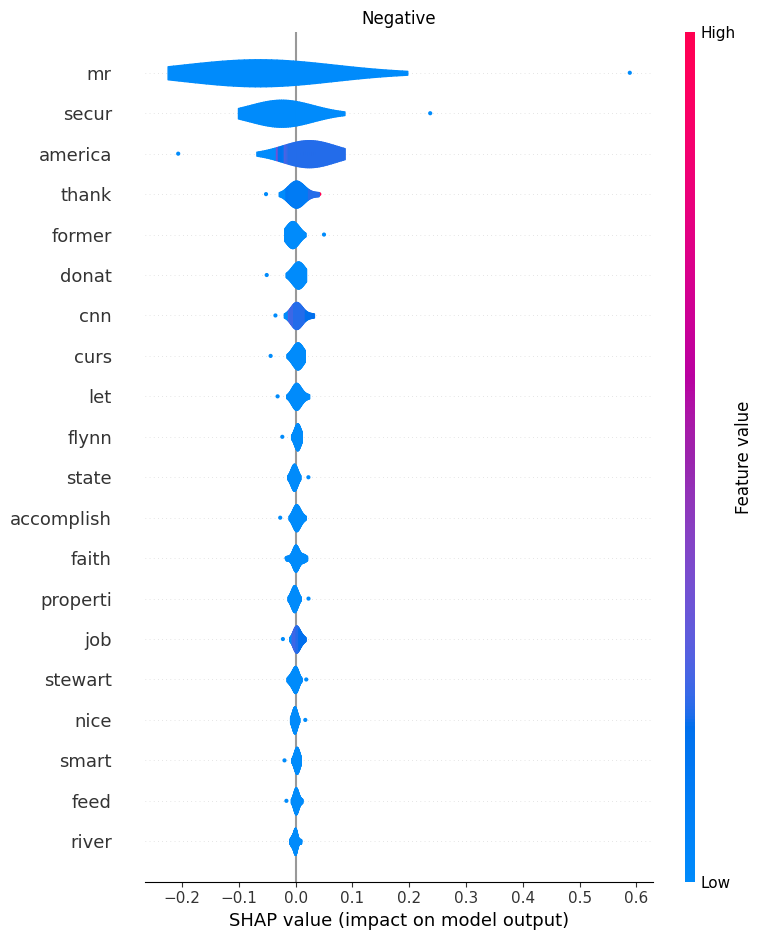

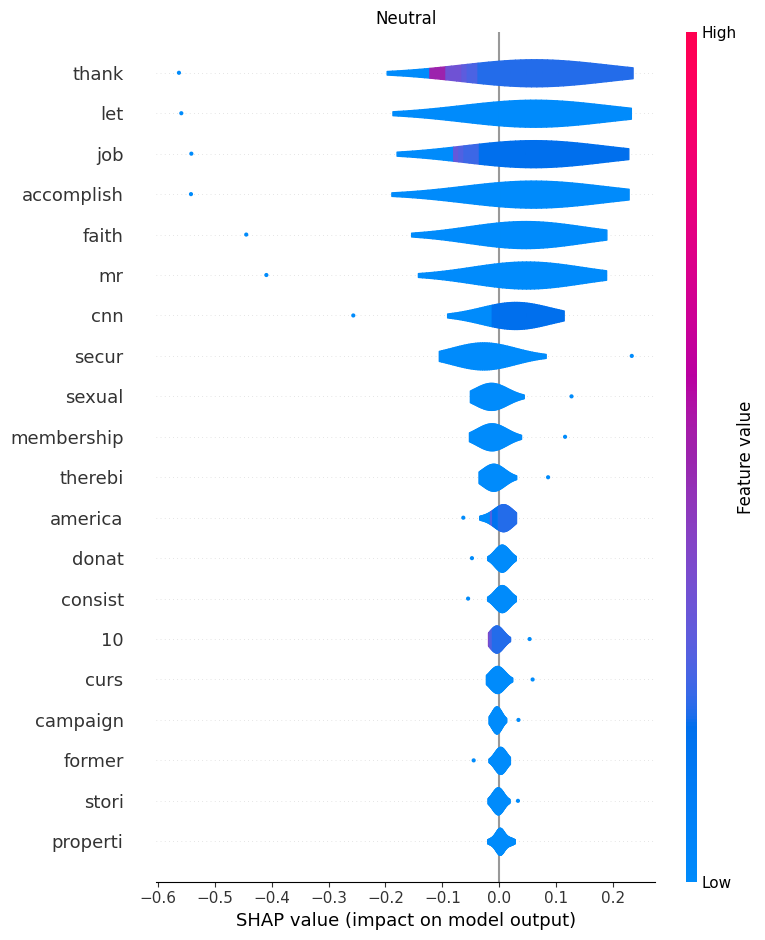

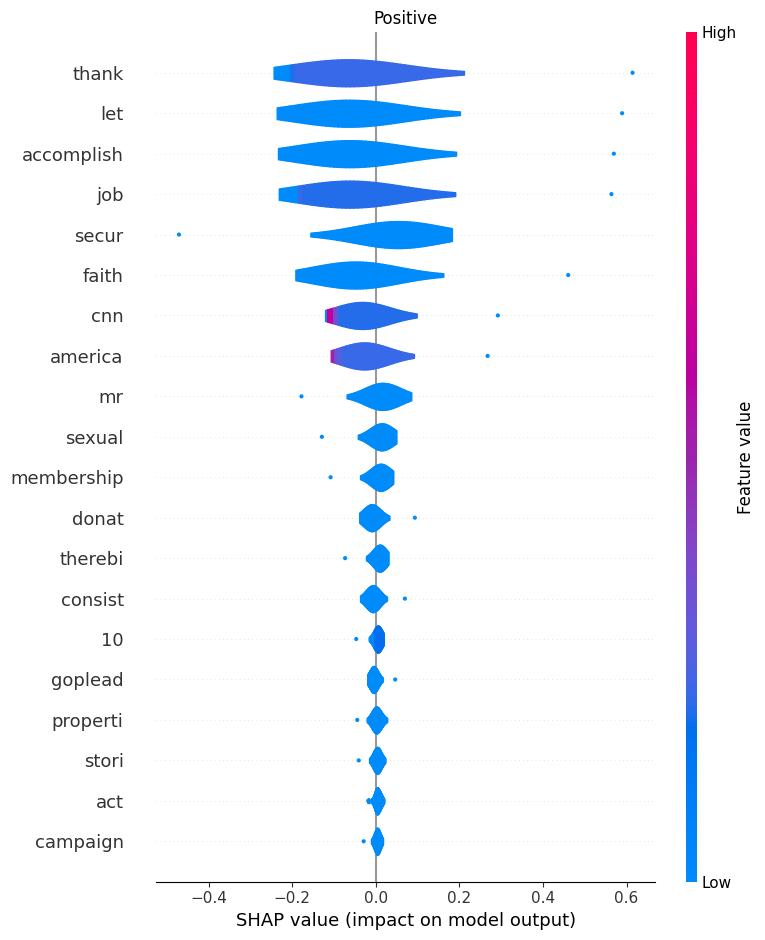

In [82]:
for i in range(3):
    plt.title(["Negative", "Neutral", "Positive"][i])
    shap.summary_plot(kernel_shap_values[i], X_train[:SHAP_NUM_OF_TWEETS],  feature_names=features_names, plot_type='violin')
    

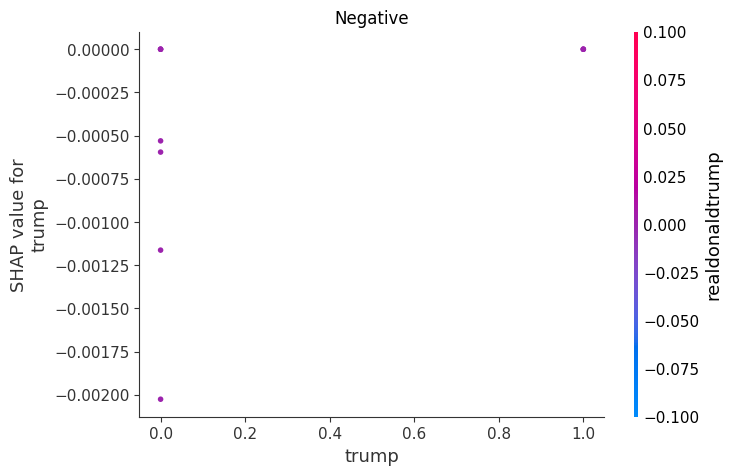

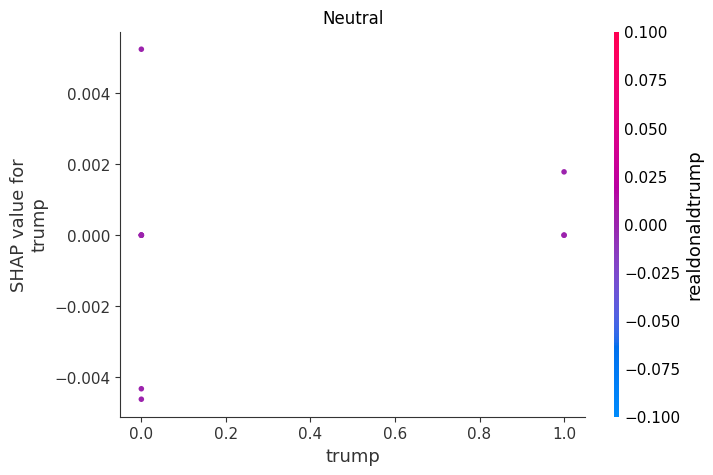

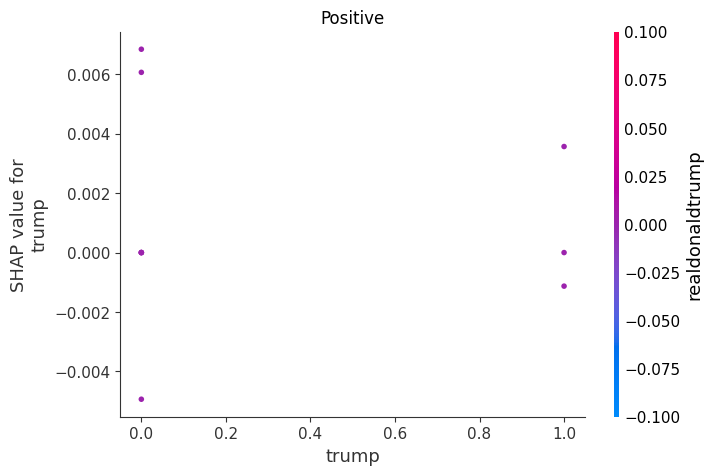

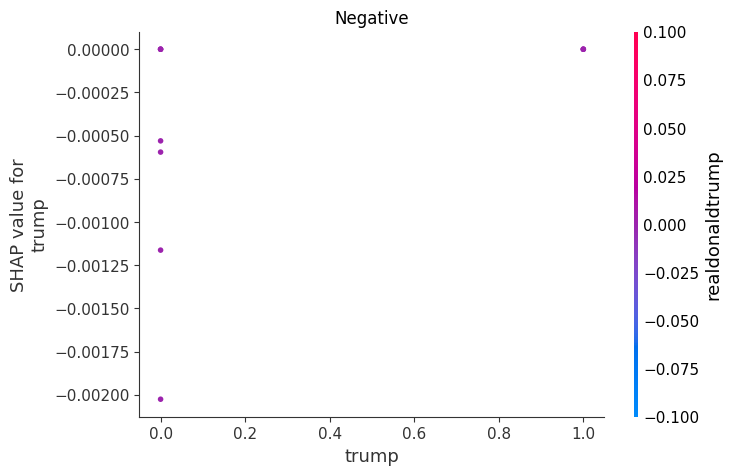

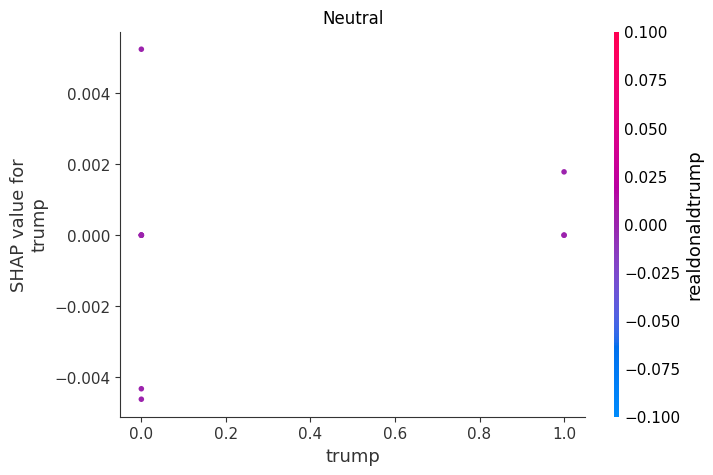

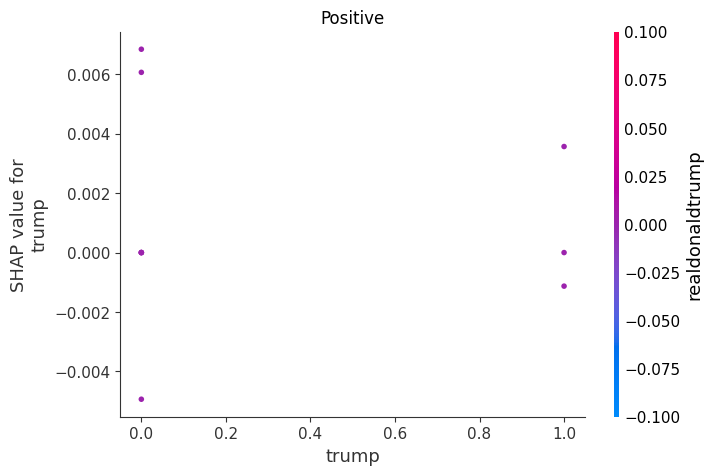

In [87]:
for i in range(3):
    shap.dependence_plot(
        "trump",
        kernel_shap_values[i],
        X_train[:SHAP_NUM_OF_TWEETS],
        feature_names=features_names,
        show=False,
    )
    plt.title(["Negative", "Neutral", "Positive"][i])
    plt.show()

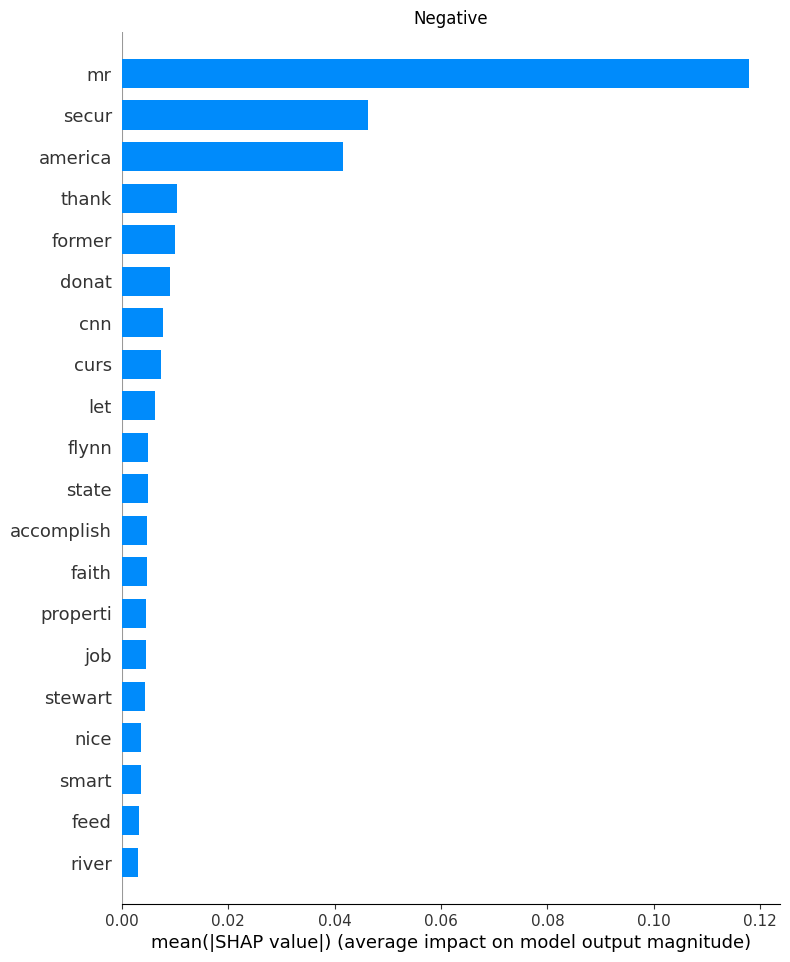

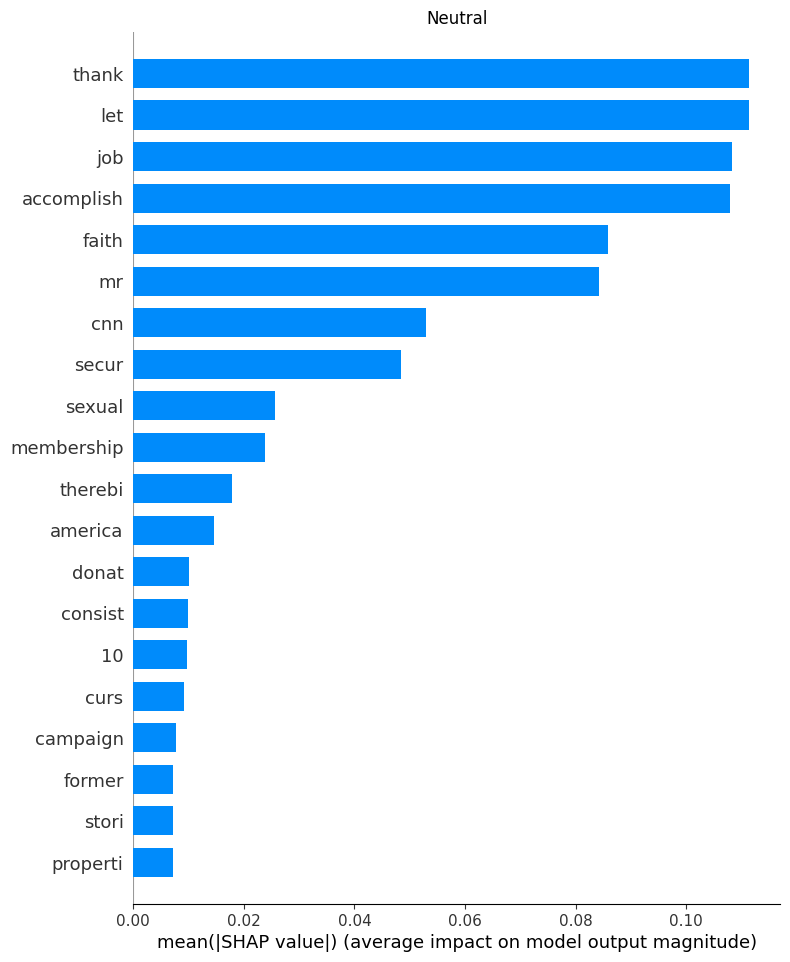

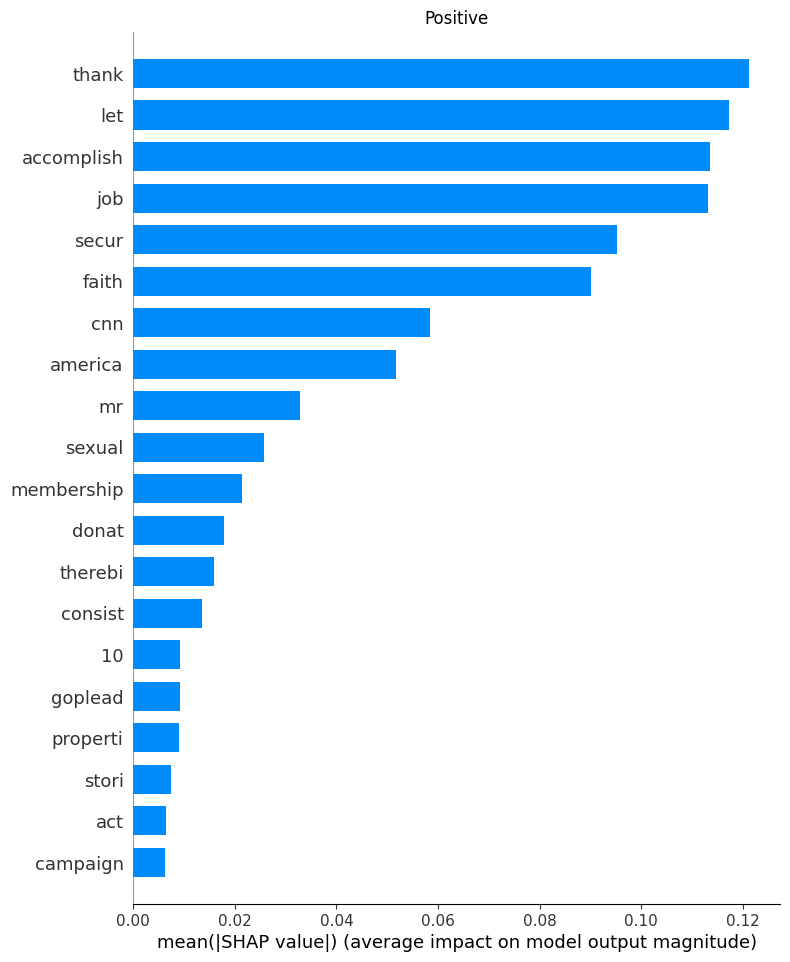

In [91]:
for i in range(3):
    shap.summary_plot(
        kernel_shap_values[i],
        features_names,
        plot_type="bar",
        class_names=["Negative", "Neutral", "Positive"],
        show=False,
    )
    plt.title(["Negative", "Neutral", "Positive"][i])
    plt.show()